In [45]:
import numpy as np
import xarray as xr
from stompy.grid import unstructured_grid
from stompy import memoize
import stompy.model.delft.dflow_model as dfm

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
model=dfm.DFlowModel.load("/opt2/suisun/2018_Suisun_R05_age/")

In [3]:
maps=model.map_outputs()

In [4]:
g=model.grid

In [5]:
g._cell_center_index=None # now patched upstream, but was missing

In [6]:
# turns out there is a missing cell in the source grid where
# Nurse Slough joins Montezuma. This step replicates the
# cell processing of DFM, which recreates this cell.
g.make_cells_from_edges()

Edge 0/197870, 0 cycles
Edge 10000/197870, 10205 cycles
Edge 20000/197870, 18912 cycles
Edge 30000/197870, 24822 cycles
Edge 40000/197870, 30748 cycles
Edge 50000/197870, 36166 cycles
Edge 60000/197870, 41558 cycles
Edge 70000/197870, 47204 cycles
Edge 80000/197870, 53107 cycles
Edge 90000/197870, 58980 cycles
Edge 100000/197870, 65286 cycles
Edge 110000/197870, 71604 cycles
Edge 120000/197870, 77812 cycles
Edge 130000/197870, 84100 cycles
Edge 140000/197870, 90301 cycles
Edge 150000/197870, 96425 cycles
Edge 160000/197870, 102818 cycles
Edge 170000/197870, 109285 cycles
Edge 180000/197870, 115599 cycles
Edge 190000/197870, 121445 cycles


In [7]:
@memoize.memoize()
def cell_mapping(proc):
    g_proc=unstructured_grid.UnstructuredGrid.from_ugrid(maps[proc])
    global_cells=np.array([g.select_cells_nearest(xy,inside=True)
                           for xy in g_proc.cells_centroid()])
    return global_cells 

In [8]:
# map local cells to global based on geometry.
ds=g.write_to_xarray()

# for now, all hard coded to be last time step
cell_vars=['mesh2d_cTr1','mesh2d_dTr1','mesh2d_RcNit','mesh2d_NO3',
           'mesh2d_flowelem_bl']

for cv in cell_vars:
    ds[cv]=('face',),np.nan*np.zeros(g.Ncells())
    
for p,fn in enumerate(maps):
    print(p)
    ds_proc=xr.open_dataset(fn).isel(time=-1)
    
    local_to_global=cell_mapping(p)
    
    for cv in cell_vars:
        local_vals=ds_proc[cv].values
        ds[cv].values[local_to_global]=local_vals
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [13]:
# Create the age fields
eps=1e-10
decay_rate=0.01 # default value in dwaq
invalid_value=-1.0 # use this value when the age tracer is too small
cTr1=ds['mesh2d_cTr1'].values
bad=cTr1<eps
ratio=ds['mesh2d_dTr1'].values/cTr1.clip(eps)
bad=bad|(ratio<eps)
age_radio=np.log10(ratio.clip(eps))/np.log10(1-decay_rate)
age_radio[bad]=invalid_value
ds['age_radio']=('face',),age_radio


In [14]:
rcnit=ds['mesh2d_RcNit'].values
bad=rcnit<eps

age_linear=ds['mesh2d_NO3'].values/ds['mesh2d_RcNit'].values.clip(eps)
age_linear[bad]=invalid_value
ds['age_linear']=('face',),age_linear

In [15]:
import stompy.plot.cmap as scmap

turbo=scmap.load_gradient('turbo.cpt')
banded=scmap.load_gradient('ncview_banded.cpt')

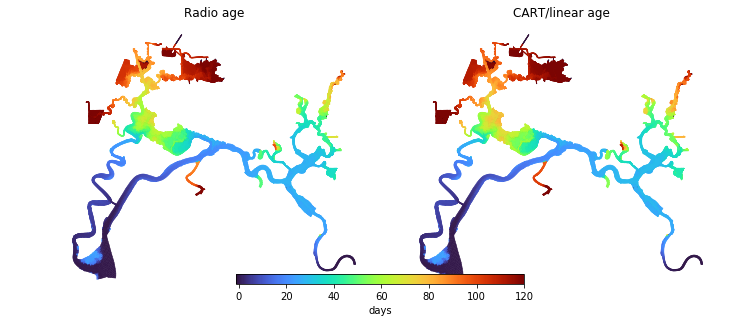

In [12]:
fig,axs=plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,4.5))

ccolls=[g.plot_cells(values=age_radio,clim=[-1,120],cmap=turbo,ax=axs[0]),
        g.plot_cells(values=age_linear,clim=[-1,120],cmap=turbo,ax=axs[1])]

for coll in ccolls:
    coll.set_edgecolor('face')
    coll.set_lw(0.5)
    
axs[0].set_title('Radio age')
axs[1].set_title('CART/linear age')
fig.tight_layout()
axs[0].axis('off')
axs[1].axis('off')

axs[0].axis('tight')
axs[0].set_aspect(1.0)

cax=fig.add_axes([0.3,0.11,0.4,0.03])
plt.colorbar(ccolls[0],cax=cax,orientation='horizontal',label='days')

fig.savefig('suisun-age-compare.png',dpi=200)

In [86]:
# And write a shapefile for sending back to Brett et al
g.add_cell_field('depth',ds.mesh2d_flowelem_bl.values,on_exists='overwrite')

g.write_cells_shp('suisun-water_age.shp',
                  extra_fields=[ ('age_radio',ds['age_radio'].values),
                                 ('age_linear',ds['age_linear'].values)],
                  overwrite=True)

0%
0.41%
0.82%
1.2%
1.6%
2.1%
2.5%
2.9%
3.3%
3.7%
4.1%
4.5%
4.9%
5.4%
5.8%
6.2%
6.6%
7%
7.4%
7.8%
8.2%
8.6%
9.1%
9.5%
9.9%
10%
11%
11%
12%
12%
12%
13%
13%
14%
14%
14%
15%
15%
16%
16%
16%
17%
17%
18%
18%
19%
19%
19%
20%
20%
21%
21%
21%
22%
22%
23%
23%
23%
24%
24%
25%
25%
26%
26%
26%
27%
27%
28%
28%
28%
29%
29%
30%
30%
30%
31%
31%
32%
32%
33%
33%
33%
34%
34%
35%
35%
35%
36%
36%
37%
37%
37%
38%
38%
39%
39%
40%
40%
40%
41%
41%
42%
42%
42%
43%
43%
44%
44%
44%
45%
45%
46%
46%
47%
47%
47%
48%
48%
49%
49%
49%
50%
50%
51%
51%
51%
52%
52%
53%
53%
54%
54%
54%
55%
55%
56%
56%
56%
57%
57%
58%
58%
58%
59%
59%
60%
60%
61%
61%
61%
62%
62%
63%
63%
63%
64%
64%
65%
65%
65%
66%
66%
67%
67%
68%
68%
68%
69%
69%
70%
70%
70%
71%
71%
72%
72%
72%
73%
73%
74%
74%
75%
75%
75%
76%
76%
77%
77%
77%
78%
78%
79%
79%
79%
80%
80%
81%
81%
82%
82%
82%
83%
83%
84%
84%
84%
85%
85%
86%
86%
86%
87%
87%
88%
88%
89%
89%
89%
90%
90%
91%
91%
91%
92%
92%
93%
93%
93%
94%
94%
95%
95%
96%
96%
96%
97%
97%
98%
98%
98%
99%
99%
1e+02%
[(

In [89]:
ds.to_netcdf('suisun-water_age.nc',mode='w')

Scale to Dispersion Coefficient
==

$$ K \propto \frac{1}{\frac{\partial ^2 a}{\partial x^2}} $$

In [20]:
# Need a tidally averaged age field first.  Otherwise 
# advection strains the age gradients.
ds_proc=xr.open_dataset(fn)
dt_s=np.median( np.diff(ds_proc.time.values)/np.timedelta64(1,'s'))

# hourly data.
# apply a godin filter just once
# Need 73 samples?




<xarray.Dataset>
Dimensions:                      (Two: 2, max_nmesh2d_face_nodes: 4, nmesh2d_edge: 13472, nmesh2d_face: 7839, nmesh2d_node: 5636, time: 4153)
Coordinates:
    mesh2d_node_x                (nmesh2d_node) float64 ...
    mesh2d_node_y                (nmesh2d_node) float64 ...
    mesh2d_edge_x                (nmesh2d_edge) float64 ...
    mesh2d_edge_y                (nmesh2d_edge) float64 ...
    mesh2d_face_x                (nmesh2d_face) float64 ...
    mesh2d_face_y                (nmesh2d_face) float64 ...
  * time                         (time) datetime64[ns] 2018-04-10 ... 2018-09-30
Dimensions without coordinates: Two, max_nmesh2d_face_nodes, nmesh2d_edge, nmesh2d_face, nmesh2d_node
Data variables:
    mesh2d                       int32 ...
    projected_coordinate_system  int32 ...
    mesh2d_node_z                (nmesh2d_node) float64 ...
    mesh2d_edge_x_bnd            (nmesh2d_edge, Two) float64 ...
    mesh2d_edge_y_bnd            (nmesh2d_edge, Two) float

In [49]:
# map local cells to global based on geometry.
ds=g.write_to_xarray()

ntimes=80
t_slice=slice(-ntimes,None) # grab the last 80 hours to have a nice Godin window

# for now, all hard coded to be last time step
cell_vars=['mesh2d_RcNit','mesh2d_NO3',
           'mesh2d_flowelem_bl','mesh2d_waterdepth']

for cv in cell_vars:
    ds[cv]=('time','face'),np.nan*np.zeros((ntimes,g.Ncells()))
    
for p,fn in enumerate(maps):
    print(p)
    ds_proc=xr.open_dataset(fn).isel(time=t_slice)
    
    local_to_global=cell_mapping(p)
    
    for cv in cell_vars:
        local_vals=ds_proc[cv].values
        ds[cv].values[:,local_to_global]=local_vals
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [50]:
rcnit=ds['mesh2d_RcNit'].values
bad=rcnit<eps

age_linear=ds['mesh2d_NO3'].values/ds['mesh2d_RcNit'].values.clip(eps)
age_linear[bad]=invalid_value
ds['age_linear']=('time','face',),age_linear

In [51]:
fake_time=np.arange(ds.dims['time']) / 24.

In [52]:
# Would be nice to use a Godin filter, but it doesn't have an axis
# argument, so would have to iterate..
N=len(fake_time)
win=np.hanning(N+2)[1:-1]
win /= win.sum()

In [53]:
age_linear_lp= (win[:,None]*age_linear).sum(axis=0)

In [40]:
# Compute second derivative of that - how?
# A shortcut is to apply a diffusion operator with unit diffusivity,
# and examine the delta.
# A few cells are not positive definite.
M=g.smooth_matrix(K=np.ones(g.Nedges()),dt=1.0)

INFO:utils:57703/189297
INFO:utils:115051/189297
INFO:utils:172524/189297


Matrix is not positive-definite. May be unstable - decrease f.
Matrix is not positive-definite. May be unstable - decrease f.
Matrix is not positive-definite. May be unstable - decrease f.
Matrix is not positive-definite. May be unstable - decrease f.
Matrix is not positive-definite. May be unstable - decrease f.
Matrix is not positive-definite. May be unstable - decrease f.
Matrix is not positive-definite. May be unstable - decrease f.


In [54]:
age_dx2=age_linear_lp - M.dot(age_linear_lp)

In [56]:
subtidal=ds.mesh2d_waterdepth.min(dim='time') > 0.10

<IPython.core.display.Javascript object>


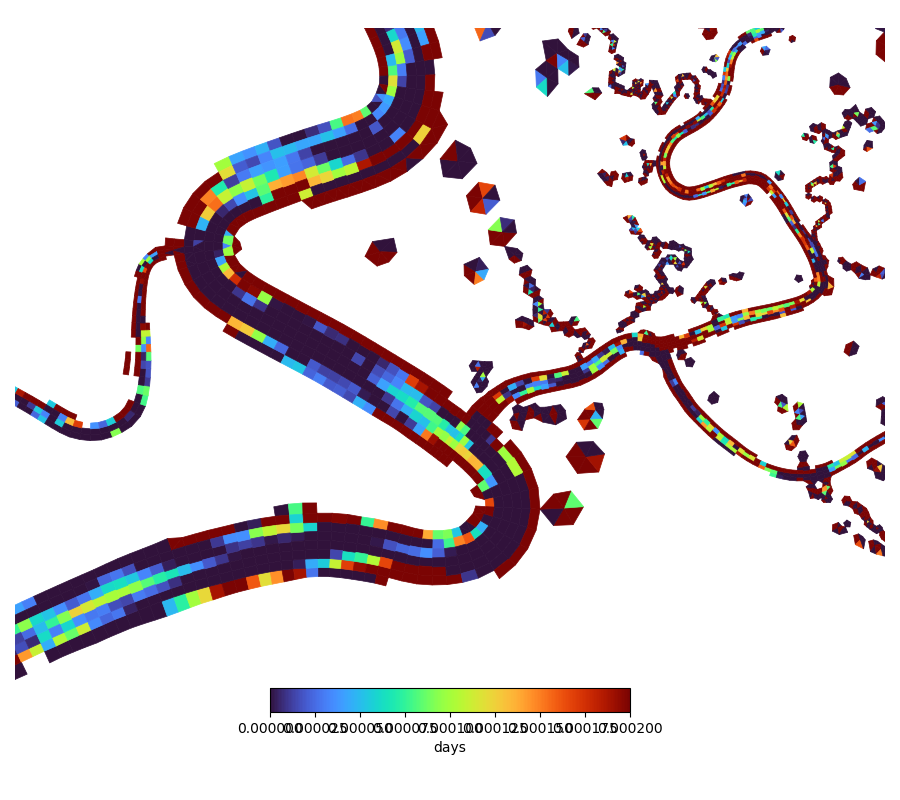

In [58]:
fig,ax=plt.subplots(1,1,figsize=(9,8))

coll=g.plot_cells(values=age_dx2,clim=[-0.01,0.01],cmap=turbo,ax=ax,mask=subtidal)

coll.set_edgecolor('face')
coll.set_lw(0.5)
    
fig.tight_layout()
ax.axis('off')
ax.axis('tight')
ax.set_aspect(1.0)

cax=fig.add_axes([0.3,0.11,0.4,0.03])
plt.colorbar(coll,cax=cax,orientation='horizontal',label='days')

In [60]:
coll.set_clim([0.0,0.0002])

<IPython.core.display.Javascript object>


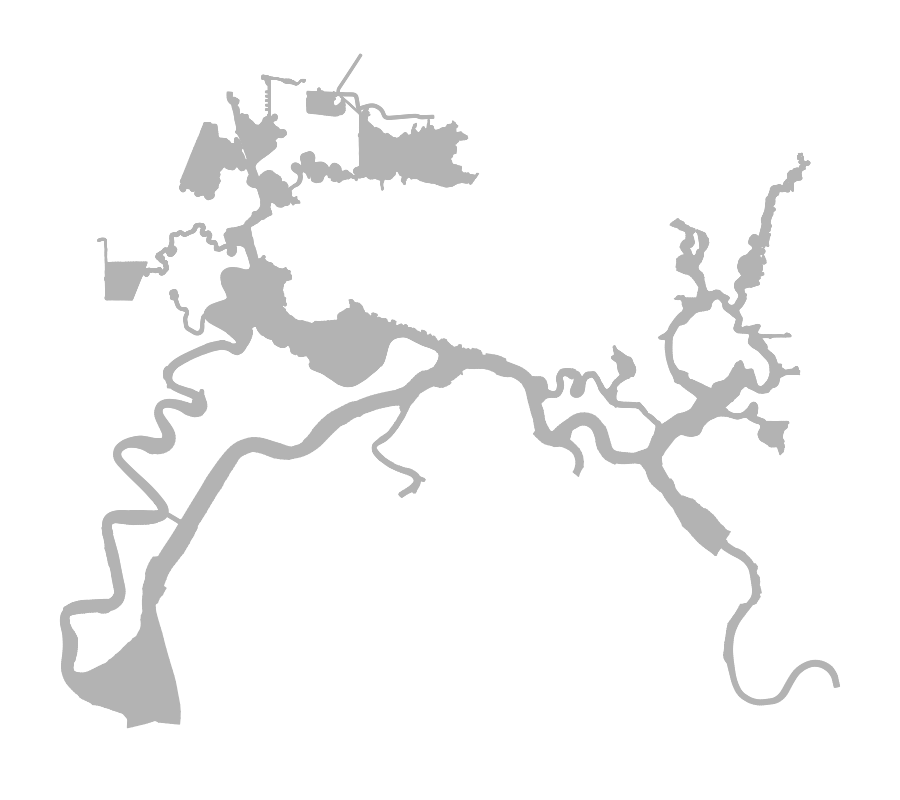

In [62]:
fig,ax=plt.subplots(1,1,figsize=(9,8))

age_subtidal=age_linear_lp.copy()
age_subtidal[~subtidal]=np.nan

cset=g.scalar_contour(age_subtidal,V=np.linspace(0,120,121))
g.plot_cells(color='0.7')

fig.tight_layout()
ax.axis('off')
ax.axis('tight')
ax.set_aspect(1.0)

